In [1]:
import sys
import os
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from scipy.signal import detrend
from pathlib import Path

sys.path.append(os.path.expanduser('~/Documents/Weave'))
from Weave.utils import collapse_restore_multiindex
from Weave.models import HybridExceedenceModel, fit_predict
from Weave.inspection import ImportanceData, scatterplot, barplot, data_for_shapplot, yplot

In [2]:
shap.initjs()

In [26]:
basepath = Path('/nobackup_1/users/straaten/hybrid_old/')
#basepath = Path('/scistor/ivm/jsn295/')
inputpath = basepath / '../clusters_cv_spearmanpar_varalpha_strict'
shaps = ImportanceData(basepath = basepath / 'shap_standard_val_q08', respagg = [31,7,3], separation = [-15,-7,-3], quantile = 0.8, model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35))
shaps.load_data(X_too = True, y_too = True, inputpath = inputpath)

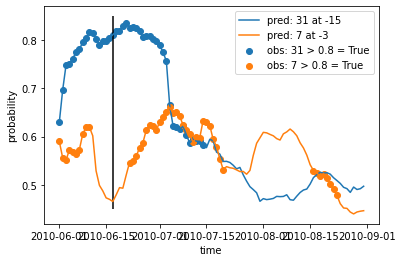

In [20]:
fig, ax = yplot(shaps, resp_sep_combinations = [(31,-15),(7,-3)], startdate = '2010-06-01', enddate = '2010-09-01')
ax.vlines(x = pd.Timestamp('2010-06-17'), ymin= 0.45, ymax = 0.85, color = 'black')

In [23]:
shaps.y.columns[2684]

Timestamp('2010-06-17 00:00:00')

In [27]:
test = data_for_shapplot(shaps, shaps.df.loc[(7,slice(None),slice(None),slice(None),slice(None),-3),:].iloc[:,[2684]].dropna(axis = 0, how = 'any'),fit_base = True)
shap.force_plot(**test)

In [5]:
test = data_for_shapplot(shaps, shaps.df.iloc[shaps.df.index.get_loc_level(11,'respagg')[0],[-50]].dropna(axis = 0, how = 'any'),fit_base = True)
shap.force_plot(**test)

In [12]:
## Same force plots but then with summed cluster contributions. (timescales too?)
shaps.reduce_over(what = ['clustid'], axis = 0, how = 'sum')
test = data_for_shapplot(shaps, shaps.df.loc[(7,slice(None),slice(None),slice(None),slice(None),-3),:].iloc[:,[2684]].dropna(axis = 0, how = 'any'), fit_base = True)
shap.force_plot(**test)

model Hybrid combination with RandomForestRegressor(max_depth=5, max_features=35, min_samples_split=30,
                      n_estimators=2500, n_jobs=15) on top of LogisticRegression with scaled time index as only input: penalty=l2, C=1.0, fit_intercept=True, with greedy base: True set baseonly to return the baserates, in a way that is compatible with non-cv base model fitting


In [ ]:
shaps.reduce_over(what = ['clustid','timeagg','lag'], axis = 0, how = 'sum')
test = data_for_shapplot(shaps, shaps.df.loc[(7,4,slice(None),-3),:].iloc[:,-92:].dropna(axis = 0, how = 'any'), fit_base = False)
shap.force_plot(**test)

In [5]:
# 2015 heatwave = 3128:
# 2019 heatwave = -92:
residuals = shaps.df.iloc[:,:].dropna(axis = 0, how = 'all').groupby(['respagg','separation']).apply(lambda df: df.sum(axis = 0)).T
baserate = shaps.get_baserate(when = residuals.index) # Not separation dependent
total = pd.DataFrame(residuals.values + baserate.loc[:,residuals.columns.get_level_values('respagg')].values, columns = residuals.columns, index = residuals.index)
binaries = shaps.get_exceedences(when = residuals.index)
# These y plots actually need dots on the lines, whether it was a true or a false.
# It almost looks as if the respagg of 11 has a stronger seasonality. I.e. the drop from june to july/august.

<AxesSubplot:xlabel='time'>

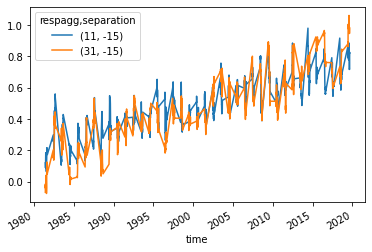

In [7]:
total.plot()

In [123]:
test2 = data_for_shapplot(shaps, shaps.df.loc[(slice(None),4),:].dropna(axis = 1, how = 'all'), fit_base=True) # Cannot do this across folds

Fitting of base value not yet implemented. Needs transformed y data


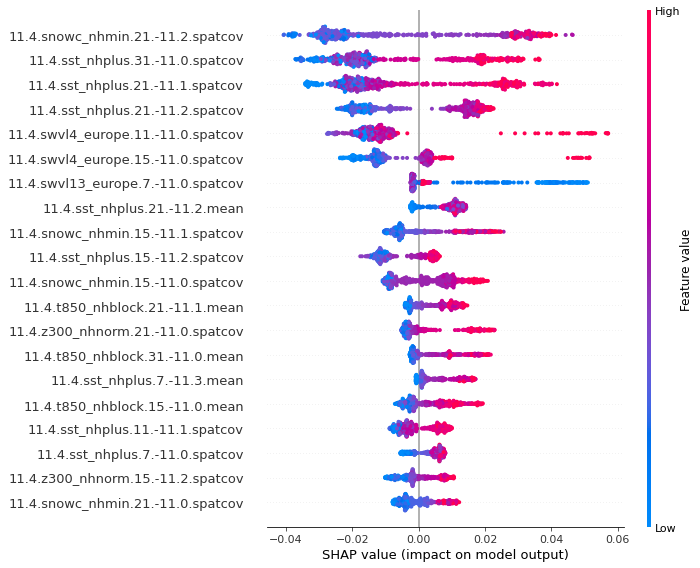

In [124]:
shap.summary_plot(**test2)

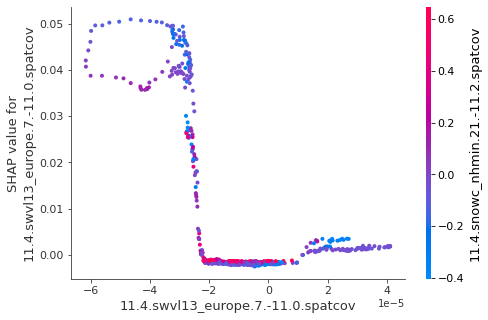

In [127]:
colvar =  '11.4.snowc_nhmin.21.-11.2.spatcov' #'3.4.snowc_nhmin.11.-3.1.spatcov' #'3.4.z300_nhnorm.5.-3.0.spatcov'
xvar = '11.4.swvl13_europe.7.-11.0.spatcov' #'3.4.sst_nhplus.31.-3.2.spatcov' #'3.4.z300_nhnorm.5.-3.0.spatcov' #'3.4.swvl4_europe.15.-3.0.spatcov' #'3.4.swvl4_europe.7.-3.0.spatcov'
shap.dependence_plot(ind = xvar, interaction_index= colvar, **test2)

Difficult to find things in the dependency plots. Some noteworthy things
* Last fold swvl4 seems less out of balance than with the previous approach.
* '3.4.snowc_nhmin.11.-3.1.spatcov' might modulate the most dominant sst a bit '3.4.sst_nhplus.31.-3.2.spatcov' short before the event. 
* Negative values of 11.4.sst_nhplus.31.15.1.spatcov seem to prohibit the utmost positive probabilistic response to 11.4.t850_nhblock.21.-15.0.mean. In fold 3 this also shows as a moderation effect (11.3.sst_nhplus.21.-15.1.spatcov on 11.3.t850_nhblock.21.-15.0.mean

Z300 influence on the thing is heightened (steeper slope) when the background sst conditions are suitable (red values), then the circulation pattern becomes decisive on whether probability is heightened or lowered.

Try to see shap differences over the folds.

In [18]:
shap_per_year = df.groupby(df.index.get_level_values('time').year).mean()
val_per_year = df_in.groupby(df_in.index.year).mean()

In [ ]:
shap.force_plot(base_value = 0.2, shap_values=shap_per_year.values, features=val_per_year.values, feature_names=df.columns, ordering_keys=val_per_year.index)

<AxesSubplot:title={'center':'swvl4_europe.15.0 at -21 days'}, xlabel='time'>

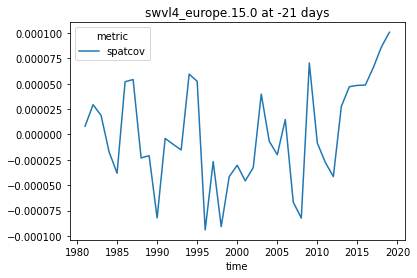

In [25]:
val_per_year[('swvl4_europe',15,-36,-21,0)].plot(title = 'swvl4_europe.15.0 at -21 days')
#val_per_year[('swvl4_europe',11,-32,-21,0)].plot()

<AxesSubplot:xlabel='time'>

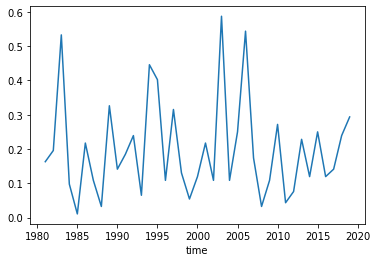

In [20]:
y.groupby(y.index.year).mean().plot()

### geographic tracing
Fold specific.

In [6]:
shaps.global_shap()

(<Figure size 288x288 with 1 Axes>,
 array([[<AxesSubplot:title={'center':'avgabsshap'}>]], dtype=object))

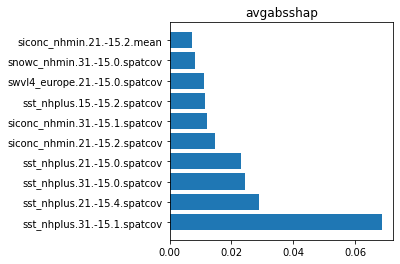

In [32]:
barplot(shaps.df.loc[(31,0,slice(None),slice(None),slice(None),-15),:], ignore_in_names=['respagg','lag','fold'])

In [13]:
shaps.df.loc[(31,0,slice(None),slice(None),slice(None),-15),:].iloc[115,]

avgabsshap    0.068802
Name: (31, 0, sst_nhplus, 31, -46, -15, 1, spatcov), dtype: float64